In [4]:
from sklearn.decomposition import PCA
import numpy as np
import os
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import evaluate_feature

In [5]:
data_dir = "../data/"

In [6]:
embeddings_path = f"{data_dir}/layer_11_embeddings_30subset.npy"

In [7]:
embeddings = np.load(embeddings_path)

In [8]:
embeddings.shape

(1972, 1003, 768)

In [9]:
num_positions = embeddings.shape[1]

In [10]:
num_positions = embeddings.shape[1]
num_seq = embeddings.shape[0]
embeddings_flattened = embeddings.reshape(-1,768)
embeddings_flattened.shape

(1977916, 768)

In [11]:
# Save the reshaped embeddings
np.save(f"{data_dir}/layer_11_embeddings_30subset_flattened.npy", embeddings_flattened)

In [12]:
scaler = StandardScaler()
embeddings_flattened = scaler.fit_transform(embeddings_flattened)

In [13]:
k = 100
pca_k = PCA(n_components=k)
pca_k_values = pca_k.fit_transform(embeddings_flattened)

# Reshape back to per sequence
pca_k_values_reshaped = pca_k_values.reshape(num_seq, num_positions,k)

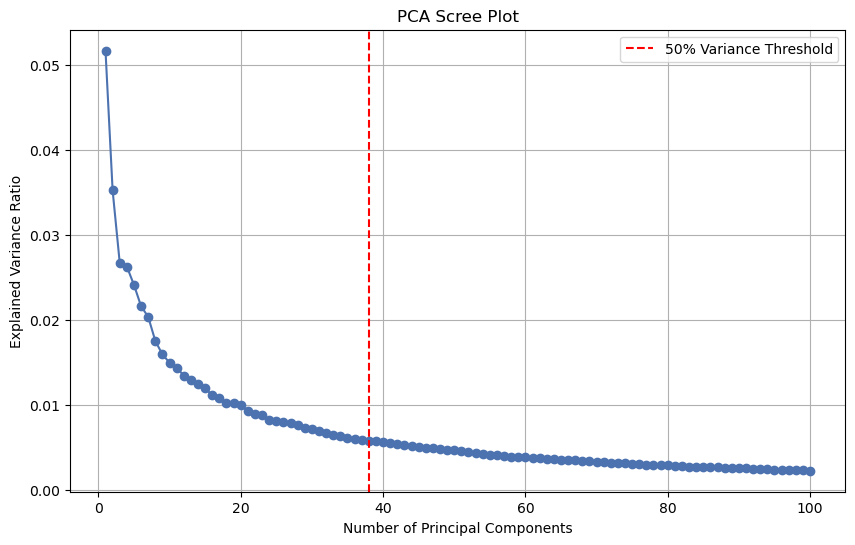

In [14]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-deep')
plt.plot(range(1, len(pca_k.explained_variance_ratio_) + 1), pca_k.explained_variance_ratio_, marker='o', linestyle='-')
#Plot line when 95% variance is reached
pca_cum = np.cumsum(pca_k.explained_variance_ratio_)
components_95 = np.where(pca_cum >= 0.50)[0][0] + 1
plt.axvline(x=components_95, color='r', linestyle='--', label='50% Variance Threshold')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()

In [15]:
# Make an elbow plot to find optimal number of clusters
inertia = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(embeddings_flattened)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
# Try with more clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clustering_5 = kmeans_5.fit_predict(embeddings_flattened)
# Reshape back with cluster annotation
clustering_5 = clustering_5.reshape(num_seq, num_positions,1)

In [16]:
ground_truth = np.load(f"{data_dir}/chip_exo_57_TF_binding_sites_30subset.npy")
ground_truth.shape

(1972, 1003, 58)

In [17]:
# Find ground truth sequences with more than 100 TFs annotated for visualization
sequences_with_more_than_100_true = []
for seq_idx in range(ground_truth.shape[0]):
    true_labels = ground_truth[seq_idx, :, 57]
    if np.sum(true_labels) > 100:
        sequences_with_more_than_100_true.append(seq_idx)

In [18]:
sequences_with_more_than_100_true

[11, 445, 536, 915, 1029, 1095, 1227, 1254, 1315, 1486]

In [22]:
# Genomic Track Matplotlib
ground_truth_track = ground_truth[11,:,57].astype(int)
plt.figure(figsize=(17, 50))
fig,axs = plt.subplots(figsize=(15, 50),nrows=100, ncols=1, sharex=True)
plt.suptitle('PCA Tracks with Ground Truth Overlay', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.style.use('seaborn-v0_8')
plt.xlabel('Position')
for pc in range(100):
    axs[pc].set_title(f'PC {pc+1}')
    axs[pc].set_xlim(200, 500)
    continuous_track = pca_k_values_reshaped[11,:,pc]
    continuous_track = (continuous_track - continuous_track.min()) / (continuous_track.max() - continuous_track.min())
    axs[pc].plot(continuous_track, label=f'PC {pc+1}', color='blue')
    axs[pc].grid(True)
    axs[pc].bar(range(len(ground_truth_track)), ground_truth_track, color='red', alpha=0.5, label='Ground Truth')

<Figure size 1700x5000 with 0 Axes>

Error in callback <function flush_figures at 0x70dd7d4e7240> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [20]:
cluster_colors = {
    0: "red",
    1: "green",
    2: "blue",
    3: "yellow",
    4: "cyan",
    5: "magenta",
    6: "orange",
    7: "purple",
    8: "brown",
    9: "pink",
    10: "gray"

}

NameError: name 'clustering_5' is not defined

<Figure size 1700x1000 with 0 Axes>

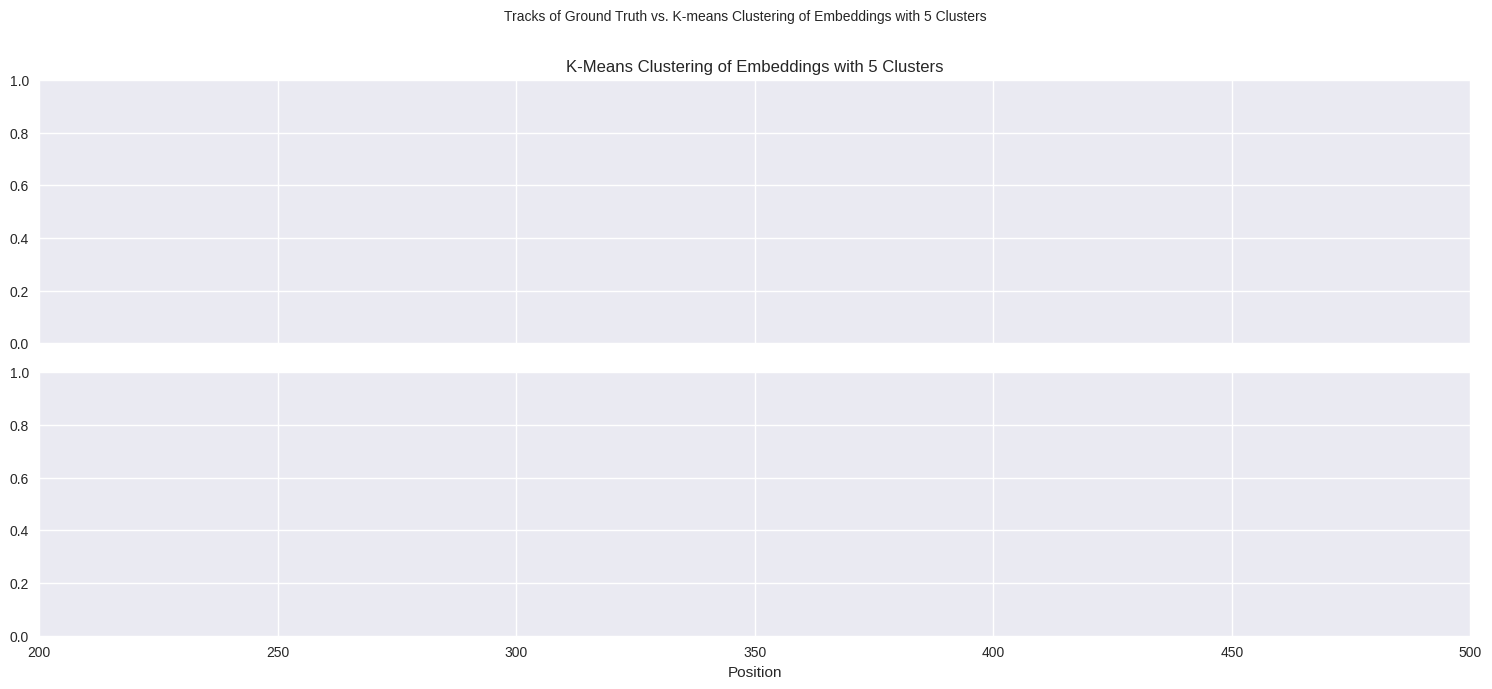

In [21]:
plt.figure(figsize=(17, 10))
fig,axs = plt.subplots(figsize=(15, 7),nrows=2, ncols=1, sharex=True)
plt.suptitle('Tracks of Ground Truth vs. K-means Clustering of Embeddings with 5 Clusters', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.style.use('seaborn-v0_8')
plt.xlabel('Position')
axs[0].set_title(f'K-Means Clustering of Embeddings with 5 Clusters')
axs[0].set_xlim(200, 500)
clustering_track = clustering_5[11,:,0]
# Different Color bar according to cluster label in clustering_10
axs[0].bar(range(len(clustering_track)), 1, color=[cluster_colors[c] for c in clustering_track], alpha=0.5, label='Clustering 10')
axs[1].set_title(f'Ground Truth')
axs[1].set_xlim(200, 500)
ground_truth_track = ground_truth[11,:,57].astype(int)
axs[1].grid(True)
axs[1].bar(range(len(ground_truth_track)), ground_truth_track, color='blue', alpha=0.5, label='Ground Truth')


In [ ]:
pca_k_values.shape

(1977916, 100)

In [ ]:
auc_matrix.shape

(1003, 1003)

In [24]:
ground_truth_flattened = ground_truth.reshape(-1, 58)
ground_truth_flattened[:, 57].shape

(1977916,)

In [25]:
auc_matrix = evaluate_feature.calculate_AUC_matrix(pca_k_values, ground_truth_flattened[:,57].reshape(-1, 1))
# Save the AUC matrix
np.save(f"{data_dir}/auc_matrices/auc_matrix.npy", auc_matrix)

Output()

In [ ]:
auc_matrix.shape

(100, 1)

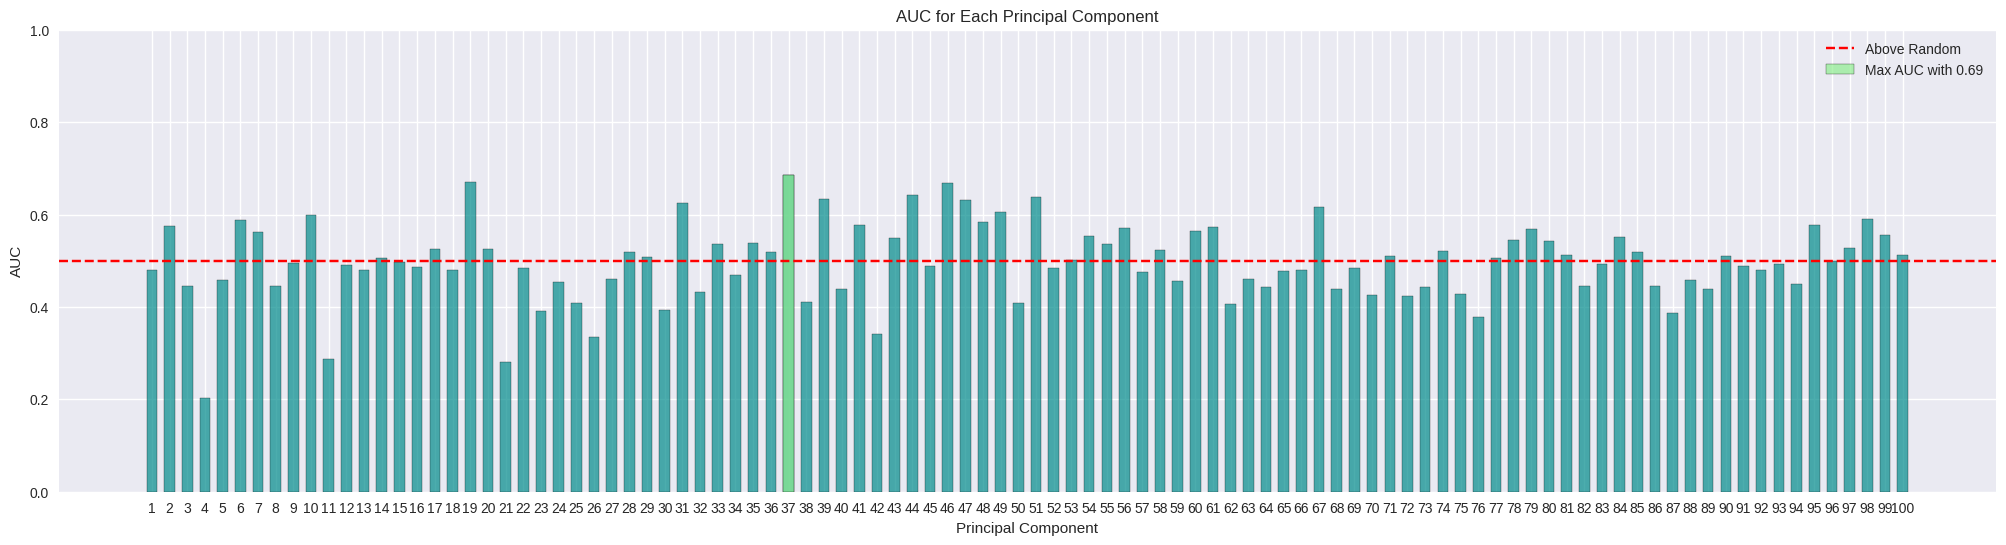

In [26]:
# Plot Bar for AUC of each PC
plt.figure(figsize=(25, 6))
plt.style.use('seaborn-v0_8-deep')
plt.bar(range(1, k + 1), auc_matrix.flatten(), color='darkcyan', edgecolor='black', width=0.6, alpha=0.7)
plt.axhline(y=0.5, color='red', linestyle='--', label='Above Random')
plt.xlabel('Principal Component')
plt.ylabel('AUC')
plt.title('AUC for Each Principal Component')

plt.ylim(0, 1)
plt.xticks(range(1, k + 1))
# color the bar with higher AUC in green
max_auc = np.max(auc_matrix)
max_auc_index = np.argmax(auc_matrix)
plt.bar(max_auc_index + 1, auc_matrix.flatten()[max_auc_index], color='lightgreen', edgecolor='black', width=0.6, alpha=0.7, label=f'Max AUC with {max_auc:.2f}')
plt.legend()

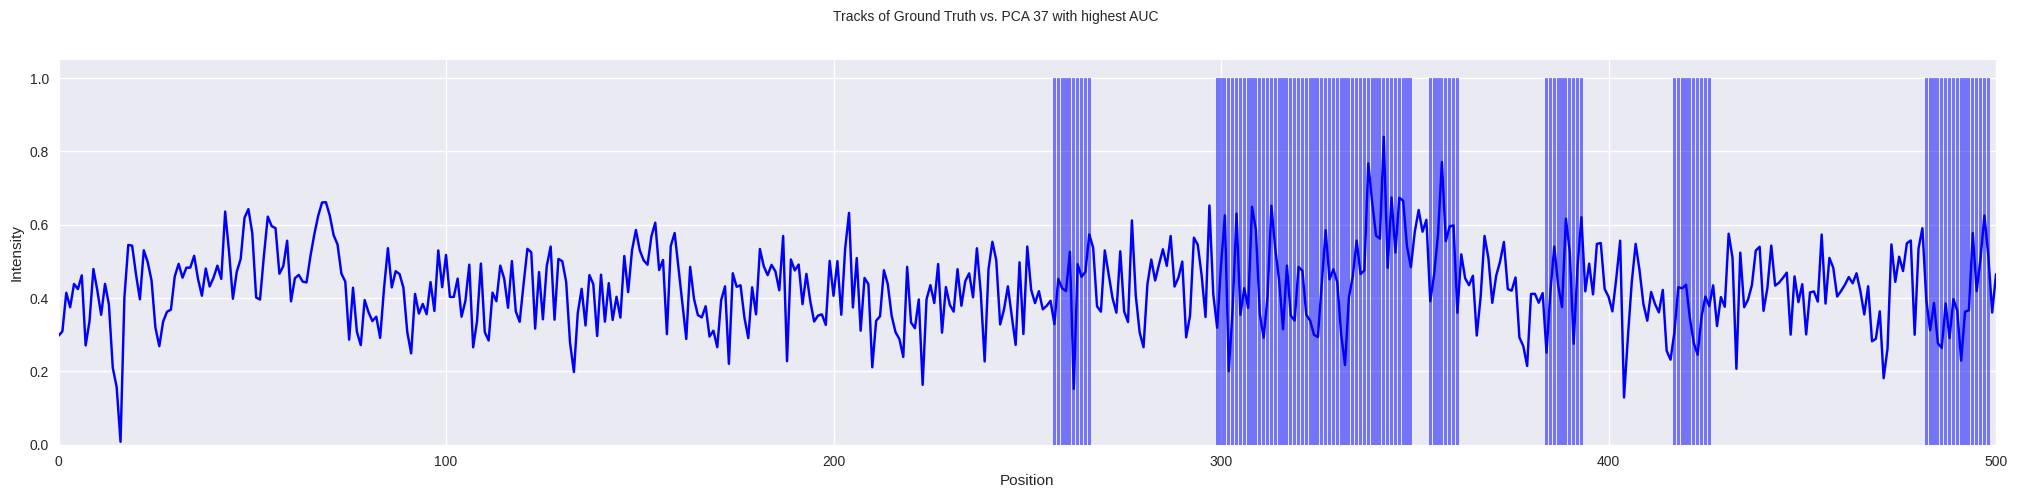

In [40]:
# Only show Pc 37 Genomic Track
plt.figure(figsize=(25, 5))
plt.suptitle('Tracks of Ground Truth vs. PCA 37 with highest AUC', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.style.use('seaborn-v0_8')
continuous_track = pca_k_values_reshaped[11,:,36]
continuous_track = (continuous_track - continuous_track.min()) / (continuous_track.max() - continuous_track.min())
plt.plot(continuous_track, label=f'PC 37', color='blue')
plt.grid(True)
ground_truth_track = ground_truth[11,:,57].astype(int)
plt.bar(range(len(ground_truth_track)), ground_truth_track, color='blue', alpha=0.5, label='Ground Truth')
plt.xlabel('Position')
plt.ylabel('Intensity')
# 200 -500
plt.xlim(0,500)
plt.show()